In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'subset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5383446%2F8946153%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T125344Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da3e5052357a6fa4d8ae13750699dc67ac5d796e8bc80fd308611e2ffe002f27d8c0a7a2dcc954d59dfb11fa43936bf4df057be430f72b28554b4ddef0a2e87eaa066fde497ba6e2675b2b52d89d9d0ce7d69d97efcb08cf7af754ea16caa169932aa7f4db1dd0c7bd022537223748846b06551a45d8fe025231707724f48a1a290135d4a18f6495601e83f7e952ca01ec175a48b9508257c4454355082a52d0a36db2d41499e1d0caa2af344496b990a21ce6469274939562cc1f84091df4168cfccae901416d94c8d0475794da5c1be539c5d3612f296a79bc150c7408f59703aae65cbc1aa846f71bcc1f84f47ca02a7b6e7c61c4eeb7b878fa5209b8d8961,sub512:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5480464%2F9083409%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T125344Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D785aac5637183653d0cd5b171ae15bce9d72eb3ddacb28bd4c0d08ccff957ae21c8e9c08424adc6af96ce07e94d5faacef77802d768a34b07f5b40732542f617c51852954bb8e686dcfad28584644b5d2d3fa6b89fd299b03a15d94d48ea30c5acf2758ec47647dd04a74b6e78dc0a89cbc484a9f0dc9c7300c4acce7e9e698c62adfeef3aa0ddb4b2ee2b97b086e246246a5844b83896b2ea959138a5ca407f0677f369d403c8d99e5e74c8ed3395bc463b9d675b766fdddbc4e369e17bd2157b0d9a7228bb685512584dd8ddb00847d7704426ae468a8f3eb127316450f96af2c4a74bedc2fbf47435903c076e1703d3d5612b11242bb4c4fa49ac1e7f3d33,bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F58437%2F70019%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T125344Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5f8eac06d68fe0013fcd40583b1033f78752a2f5ce883fa24fc66c0dc4d9a6a4d5e351cf46ead81642ad0409248373832cdd6fc429baf55eaea9b6aaa453c5f12f806f81fa4fd07f4c57c4c960d3450e038ebe731102cc1231a13336a29280ca3941abcabd11c3e98176fae409f3286d7aeadc9fa0a805a9e9b098a3828035b3c8f69adbbad9761081de2f2f9df42b36a07176ffe65ceda3907b4e7bb485b354ed8959594e3623410223eab7d406bb7b334acf5a4ebf7571f6ebc7400dc9c6c794c56688f6970d1f69d1b1ac656d93fcbff927ab5f0d82fb8ad36966e82850e4311297b1f951e858e2ea4647da2eacc83d5c043e84d1bfc7afe50cfee53affd3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2162729 bytes downloaded
Downloaded and uncompressed: subset
[==================================================] 439052 bytes downloaded
Downloaded and uncompressed: sub512
[==================================================] 408706476 bytes downloaded
Downloaded and uncompressed: bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sub512/sub512.pkl
/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-tokenizer/tokenizer_config.json
/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-tokenizer/special_tokens_map.json
/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-tokenizer/vocab.txt
/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-model/config.json
/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-model/model.safetensors
/kaggle/input/subset/subset.pkl


In [ ]:
# !pip install focal-loss

In [ ]:
# from focal_loss import BinaryFocalLoss

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
import torch.backends.cudnn
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda:0


In [ ]:
import random

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
set_seed(42)

In [ ]:
torch.use_deterministic_algorithms(True)


In [ ]:
model_path = os.path.join('/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-model')
tokenizer_path = os.path.join('/kaggle/input/bert-base-italian-cased-model/pytorch/bert-base-italian-cased/1/bert-base-italian-cased-tokenizer')

from transformers import AutoModel, AutoTokenizer

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# # TRAIN

In [ ]:
num_classes = 2

model.classifier = nn.Linear(model.config.hidden_size, num_classes)
model.classifier.to(device)

#weights=torch.tensor([1.0,1.0]) #TOGLIERE PER USARE LOSS NORMALE
loss_fn = nn.BCELoss() #prima CrossEntropyLoss() o BCELoss() per usare la binary cross entropy

# optimizer (AdamW)
lr=0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-2)

num_epochs = 8
batch_size = 32

In [ ]:
#df_train0 = pd.read_pickle('/kaggle/input/sub512/sub512.pkl')
#df_test = pd.read_pickle('/kaggle/input/sub512/sub512.pkl')
df_train0 = pd.read_pickle('/content/final_aug.pkl')
df_test = pd.read_pickle('/content/final_aug.pkl')

In [ ]:
df_train0

,link,text,label,textlen,translated_text
0,https://www.liberoquotidiano.it/news/politica/...,05 maggio 2024 a\n\na\n\na\n\nForza Italia cre...,0,263,"May 5, 2024 a\n\na\n\na\n\nForza Italia is gro..."
1,https://www.liberoquotidiano.it/news/italia/39...,05 maggio 2024 a\n\na\n\na\n\nTragedia in Valt...,0,190,"May 5, 2024 a\n\na\n\na\n\nTragedy in Valtelli..."
2,https://www.liberoquotidiano.it/news/sport/392...,"05 maggio 2024 a\n\na\n\na\n\nScarico, demotiv...",0,353,"May 5, 2024 a\n\na\n\na\n\nExhausted, demotiva..."
3,https://www.liberoquotidiano.it/news/sport/392...,05 maggio 2024 a\n\na\n\na\n\nDomenica importa...,0,283,"May 5, 2024 a\n\na\n\na\n\nAn important Sunday..."
4,https://salerno.corriere.it/notizie/cronaca/24...,di Luigi Martino\n\nSolo sei iscritti tra i 3 ...,0,327,by Luigi Martino\n\nOnly six children between ...
...,...,...,...,...,...
1095,augmented,"33, quinto comma, della Costituzione, che pres...",1,-1,"33, fifth paragraph, of the Constitution, whic..."
1096,augmented,,1,-1,"[33, fifth paragraph, of the Constitution, whi..."
1097,augmented,"33, quinto comma, della Costituzione, Che pres...",1,-1,"33, fifth paragraph, of the Constitution, Whic..."
1098,augmented,"33, comma 5, della Costituzione, che prescrive...",1,-1,"33, 5th paragraph, of the Constitution, which ..."


In [ ]:
# df_train0

In [ ]:
# #df_train0=df_train0.drop(columns=['link', 'keyword', 'flag'])
# #df_test=df_test.drop(columns=['link', 'keyword', 'flag'])
# df_train0=df_train0.drop(columns=['link'])
# df_test=df_test.drop(columns=['link'])

In [ ]:
# df_train0 = df_train0[df_train0['label'].notna()]
# df_test = df_test[df_test['label'].notna()]


In [ ]:
df_train, df_val = train_test_split(df_train0, test_size=0.3, random_state=42)

In [ ]:
df_train.shape, df_val.shape

((770, 5), (330, 5))

In [ ]:
# Prepara i dati di allenamento
#contexts = df_train['Prompt'].tolist()
#target_sentences = df_train['Target'].tolist()
texts=df_train['text'].tolist()
labels = df_train['label'].tolist()

In [ ]:
# Tokenizza i dati e convertili in tensori PyTorch
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=512, #450?
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
import os
import torch

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Check if deterministic algorithms are enabled
if torch.are_deterministic_algorithms_enabled():
    print("Warning: Deterministic algorithms are enabled.")
    # Consider disabling if not strictly necessary
    # torch.use_deterministic_algorithms(False)


# OVERSAMPLING?

In [ ]:
# import ktrain


In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

dataset = TensorDataset(input_ids, attention_masks, labels)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# criterion = BinaryFocalLoss(gamma=2.0) #TOGLIERE PER USARE ACCURACY

# Addestra il modello
train_losses = []
val_losses = []
train_recalls=[]
val_recalls=[]
train_accuracies = []
val_accuracies = []

#STAMPA TUTTI GLI IPERPARAMETRI:
print('HYPERPARAMETERS:', '\n #epochs=', num_epochs, 'batch size=', batch_size, 'loss function=', loss_fn, 'optimizer=', optimizer, 'lr=', lr)

for epoch in range(num_epochs):
  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  # Training phase
  model.train()
  train_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  true_positives=0
  false_negatives=0

  for batch in tqdm(dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    optimizer.zero_grad()
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    loss = outputs.loss 
    logits = outputs.logits
    train_loss += loss.item()
    _, predicted = torch.max(logits, 1) 
    correct_predictions += (predicted == b_labels).sum().item()
    total_samples += b_labels.size(0)
    loss.backward()
    optimizer.step()

  epoch_loss = train_loss / len(dataloader)
  epoch_accuracy = correct_predictions / total_samples

  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  print(f'Training Loss: {epoch_loss:.4f}')
  print(f'Training Accuracy: {epoch_accuracy:.4f}')


  # Validation phase
  model.eval()
  val_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  with torch.no_grad():
    for batch in dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels)


      loss = outputs.loss 
      logits = outputs.logits
      val_loss += loss.item()

      _, predicted = torch.max(logits, 1)
      correct_predictions += (predicted == b_labels).sum().item()
      total_samples += b_labels.size(0)


  epoch_loss = val_loss / len(dataloader)
  epoch_accuracy = correct_predictions / total_samples
  val_losses.append(epoch_loss)
  val_accuracies.append(epoch_accuracy)
  print(f'Validation Loss: {epoch_loss:.4f}')
  print(f'Validation Accuracy: {epoch_accuracy:.4f}')


# Print and store the results
print('\nTraining complete.')
print('Training losses:', train_losses)
print('Validation losses:', val_losses)
print('Training accuracies:', train_accuracies)
print('Validation accuracies:', val_accuracies)


HYPERPARAMETERS: 
 #epochs= 8 batch size= 32 loss function= BCELoss() optimizer= AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 0.01
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
) lr= 0.0001
Epoch 1/8
----------


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


Training Loss: 0.6569
Training Accuracy: 0.6519
Validation Loss: 0.6056
Validation Accuracy: 0.7844
Epoch 2/8
----------


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


Training Loss: 0.5577
Training Accuracy: 0.7545
Validation Loss: 0.4782
Validation Accuracy: 0.8221
Epoch 3/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


Training Loss: 0.4164
Training Accuracy: 0.8429
Validation Loss: 0.3385
Validation Accuracy: 0.8792
Epoch 4/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


Training Loss: 0.3105
Training Accuracy: 0.9013
Validation Loss: 0.2131
Validation Accuracy: 0.9429
Epoch 5/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


Training Loss: 0.2243
Training Accuracy: 0.9130
Validation Loss: 0.1543
Validation Accuracy: 0.9532
Epoch 6/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


Training Loss: 0.1640
Training Accuracy: 0.9429
Validation Loss: 0.0887
Validation Accuracy: 0.9805
Epoch 7/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


Training Loss: 0.0943
Training Accuracy: 0.9740
Validation Loss: 0.0516
Validation Accuracy: 0.9922
Epoch 8/8
----------


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


Training Loss: 0.0462
Training Accuracy: 0.9896
Validation Loss: 0.0269
Validation Accuracy: 0.9961

Training complete!
Training losses: [0.6569387745857239, 0.5577479922771453, 0.41638194799423217, 0.3105152130126953, 0.22427159070968627, 0.1639753146469593, 0.09432162627577782, 0.04618646133691073]
Validation losses: [0.6055637049674988, 0.4782189452648163, 0.3384967917203903, 0.21307782858610153, 0.15431818202137948, 0.08871156476438045, 0.05159886792302132, 0.026949935778975486]
Training accuracies: [0.6519480519480519, 0.7545454545454545, 0.8428571428571429, 0.9012987012987013, 0.912987012987013, 0.9428571428571428, 0.974025974025974, 0.9896103896103896]
Validation accuracies: [0.7844155844155845, 0.8220779220779221, 0.8792207792207792, 0.9428571428571428, 0.9532467532467532, 0.9805194805194806, 0.9922077922077922, 0.9961038961038962]


In [ ]:
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

In [ ]:
# #DataLoader per gestire i dati di allenamento
# dataset = TensorDataset(input_ids, attention_masks, labels)
# #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


In [ ]:
# # Loop di allenamento
# torch.cuda.empty_cache()
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(dataloader):
#         # Estrai i dati dal batch
#         batch = tuple(t.to(device) for t in batch)
#         b_input_ids, b_attention_masks, b_labels = batch

    #     #gradienti
    #     optimizer.zero_grad()

    #     #forward pass
    #     outputs = model(b_input_ids, attention_mask=b_attention_masks, labels=b_labels)
    #     loss = outputs.loss

    #     #backward pass
    #     loss.backward()

    #     #pesi
    #     optimizer.step()

    #     total_loss += loss.item()

    # avg_loss = total_loss / len(dataloader)
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Validation (DA CAMBIARE)

In [ ]:
# Prepara i dati di allenamento
text_test = df_val['text'].tolist()
labels_test = df_val['label'].tolist()

In [ ]:
input_ids_test = []
attention_masks_test = []

for text in text_test:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=512,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

In [ ]:
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

In [ ]:
# Crea il DataLoader per gestire i dati di test
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
model.eval()
predictions = []
true_labels = []

for batch in dataloader_test:
    #Estrai i dati dal batch
    b_input_ids, b_attention_masks, b_labels = batch

    with torch.no_grad():
        #forward pass
        outputs = model(b_input_ids.cuda(), attention_mask=b_attention_masks.cuda())
        logits = outputs.logits

    #predizioni
    _, predicted_labels = torch.max(logits, dim=1)
    predictions.extend(predicted_labels.tolist())
    true_labels.extend(b_labels.tolist())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       155
           1       0.94      0.99      0.96       175

    accuracy                           0.96       330
   macro avg       0.96      0.96      0.96       330
weighted avg       0.96      0.96      0.96       330


Confusion Matrix:


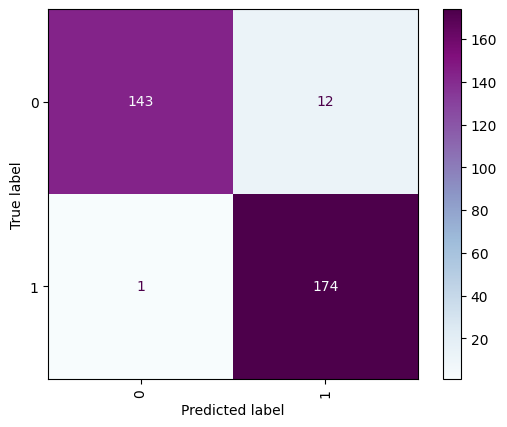

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, predictions))
print()

print("Confusion Matrix:")
print(ConfusionMatrixDisplay.from_predictions(true_labels, predictions, xticks_rotation='vertical', cmap='BuPu'))

# VALIDATION SU ALTRI TESTI

In [ ]:
frase1="I meridionali sono tutti ladri"
frase2="Indagato l'artista Morgan per accusa di stalking e violenza sessuale, l'artista avrebbe anche avuto comportamenti a dir poco preoccupanti, ad esempio ingaggiare due siciliani per pedinare l'ex fidanzata"
frase3="Alle persone meridionali piace fare le vittime"
frase4="Eccellenza napoletana, l'ospedale Pascale testa una nuova procedura non invasiva per l'asporto di tumori della pelle"
frase5=""
text_test=[frase1, frase2, frase3, frase4]
labels_test=[1,1,1,0]


In [ ]:
# Prepara i dati di allenamento
#text_test = df_val['text'].tolist()
#labels_test = df_val['label'].tolist()

In [ ]:
# Tokenizza i dati di test e convertili in tensori PyTorch
input_ids_test = []
attention_masks_test = []

for text in text_test:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=512,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

In [ ]:
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

In [ ]:
# Crea il DataLoader per gestire i dati di test
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
# Esegui l'inferenza sul dataset di test
model.eval()
predictions = []
true_labels = []

for batch in dataloader_test:
    # Estrai i dati dal batch
    b_input_ids, b_attention_masks, b_labels = batch

    with torch.no_grad():
        # Esegui il forward pass
        outputs = model(b_input_ids.cuda(), attention_mask=b_attention_masks.cuda())
        logits = outputs.logits

    # Ottieni le predizioni
    _, predicted_labels = torch.max(logits, dim=1)
    predictions.extend(predicted_labels.tolist())
    true_labels.extend(b_labels.tolist())

In [ ]:
predictions

[1, 0, 1, 0]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4


Confusion Matrix:


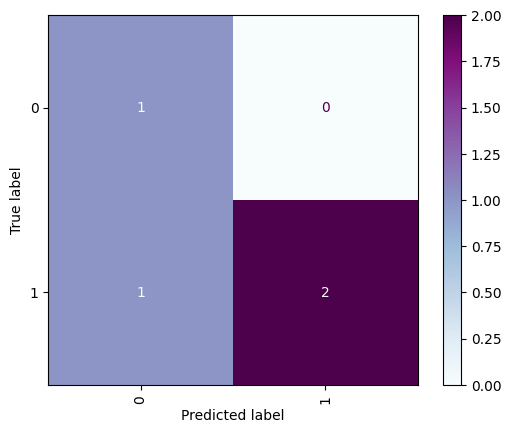

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, predictions))
print()

print("Confusion Matrix:")
print(ConfusionMatrixDisplay.from_predictions(true_labels, predictions, xticks_rotation='vertical', cmap='BuPu'))

# Salva modello 1
###HYPERPARAMETERS:
 #epochs= 12 batch size= 32 loss function= BCELoss() optimizer= AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 0.01
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
) lr= 0.001

In [ ]:
# # Salva il modello
# output_dir = './modello_salvato/'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)


In [ ]:
# # Carica il modello salvato
# model_path = './modello_salvato/'
# tokenizer_loaded = BertTokenizer.from_pretrained(model_path)
# model_loaded = BertForSequenceClassification.from_pretrained(model_path)
# model_loaded.to(device)


# Salva modello 2
###HYPERPARAMETERS:
 #epochs= 8 batch size= 32 loss function= BCELoss() optimizer= AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 0.01
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
) lr= 0.0001

In [ ]:
# Salva il modello
output_dir = './modello_2/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('./modello_2/tokenizer_config.json',
 './modello_2/special_tokens_map.json',
 './modello_2/vocab.txt',
 './modello_2/added_tokens.json')

In [ ]:
# Carica il modello salvato
model_path = './modello_2/'
tokenizer_loaded = BertTokenizer.from_pretrained(model_path)
model_loaded = BertForSequenceClassification.from_pretrained(model_path)
model_loaded.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# LONGFORMER

In [ ]:
#Transformer
import torch
from transformers import LongformerModel, LongformerTokenizer

In [ ]:
df_train0['len_text']=df_train0['text'].apply(lambda x : len(x))
df_train0

,link,text,label,textlen,translated_text,len_text
0,https://www.liberoquotidiano.it/news/politica/...,05 maggio 2024 a\n\na\n\na\n\nForza Italia cre...,0,263,"May 5, 2024 a\n\na\n\na\n\nForza Italia is gro...",1678
1,https://www.liberoquotidiano.it/news/italia/39...,05 maggio 2024 a\n\na\n\na\n\nTragedia in Valt...,0,190,"May 5, 2024 a\n\na\n\na\n\nTragedy in Valtelli...",1111
2,https://www.liberoquotidiano.it/news/sport/392...,"05 maggio 2024 a\n\na\n\na\n\nScarico, demotiv...",0,353,"May 5, 2024 a\n\na\n\na\n\nExhausted, demotiva...",2196
3,https://www.liberoquotidiano.it/news/sport/392...,05 maggio 2024 a\n\na\n\na\n\nDomenica importa...,0,283,"May 5, 2024 a\n\na\n\na\n\nAn important Sunday...",1678
4,https://salerno.corriere.it/notizie/cronaca/24...,di Luigi Martino\n\nSolo sei iscritti tra i 3 ...,0,327,by Luigi Martino\n\nOnly six children between ...,2092
...,...,...,...,...,...,...
1095,augmented,"33, quinto comma, della Costituzione, che pres...",1,-1,"33, fifth paragraph, of the Constitution, whic...",2257
1096,augmented,,1,-1,"[33, fifth paragraph, of the Constitution, whi...",0
1097,augmented,"33, quinto comma, della Costituzione, Che pres...",1,-1,"33, fifth paragraph, of the Constitution, Whic...",2230
1098,augmented,"33, comma 5, della Costituzione, che prescrive...",1,-1,"33, 5th paragraph, of the Constitution, which ...",2245


In [ ]:
from google.colab import files

files.download('/content/modello_2/model.safetensors')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>